# Overview of the Pollen development kit

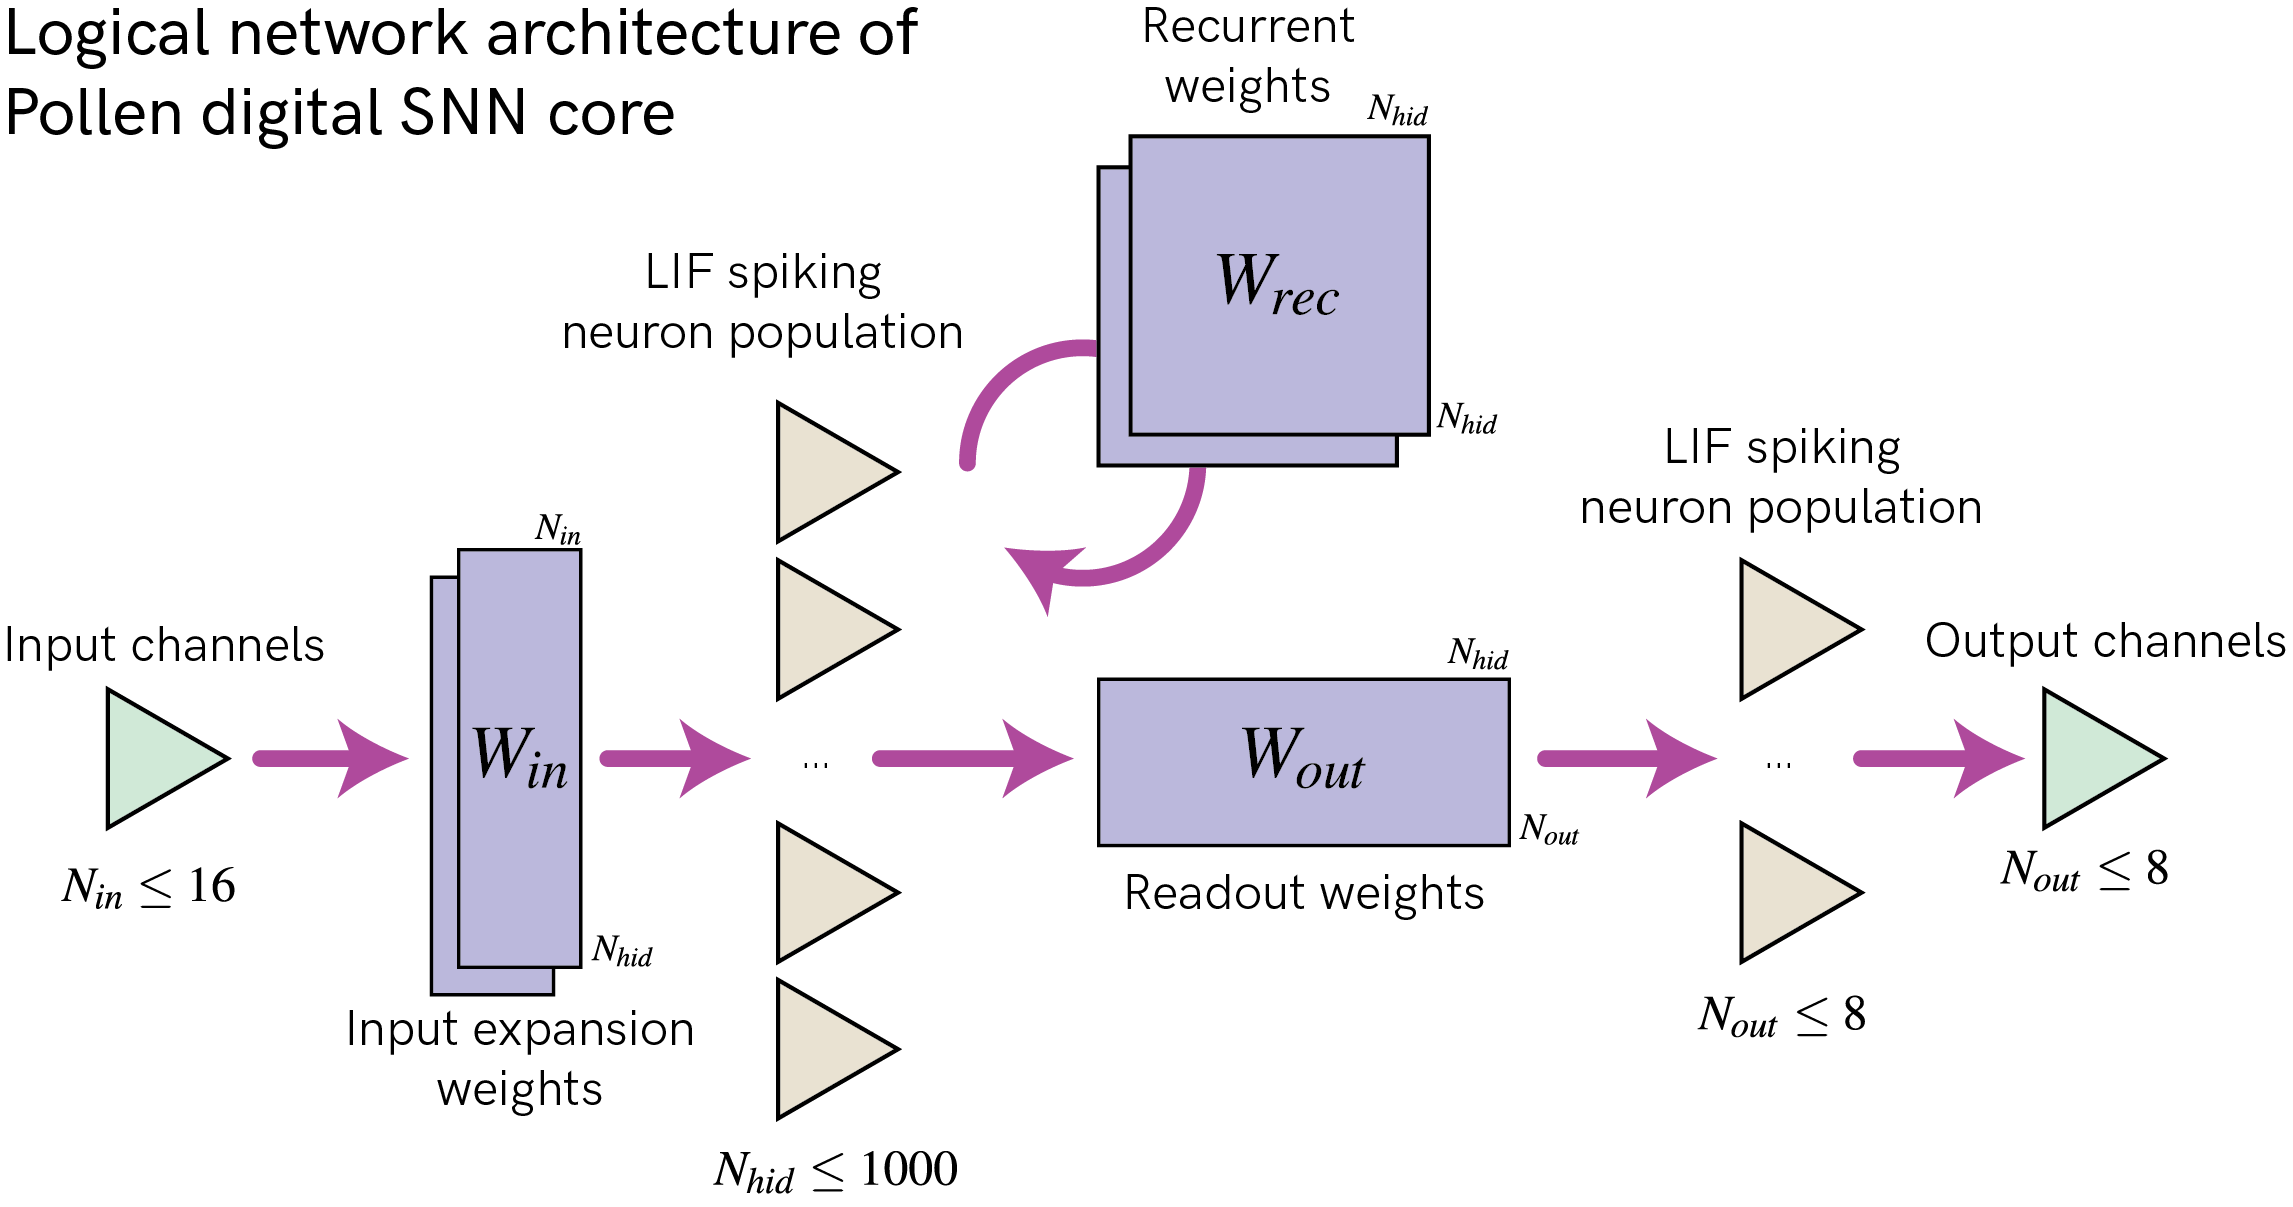

In [1]:
# - Image display
from IPython.display import Image
Image("images/pollen_network-architecture.png")

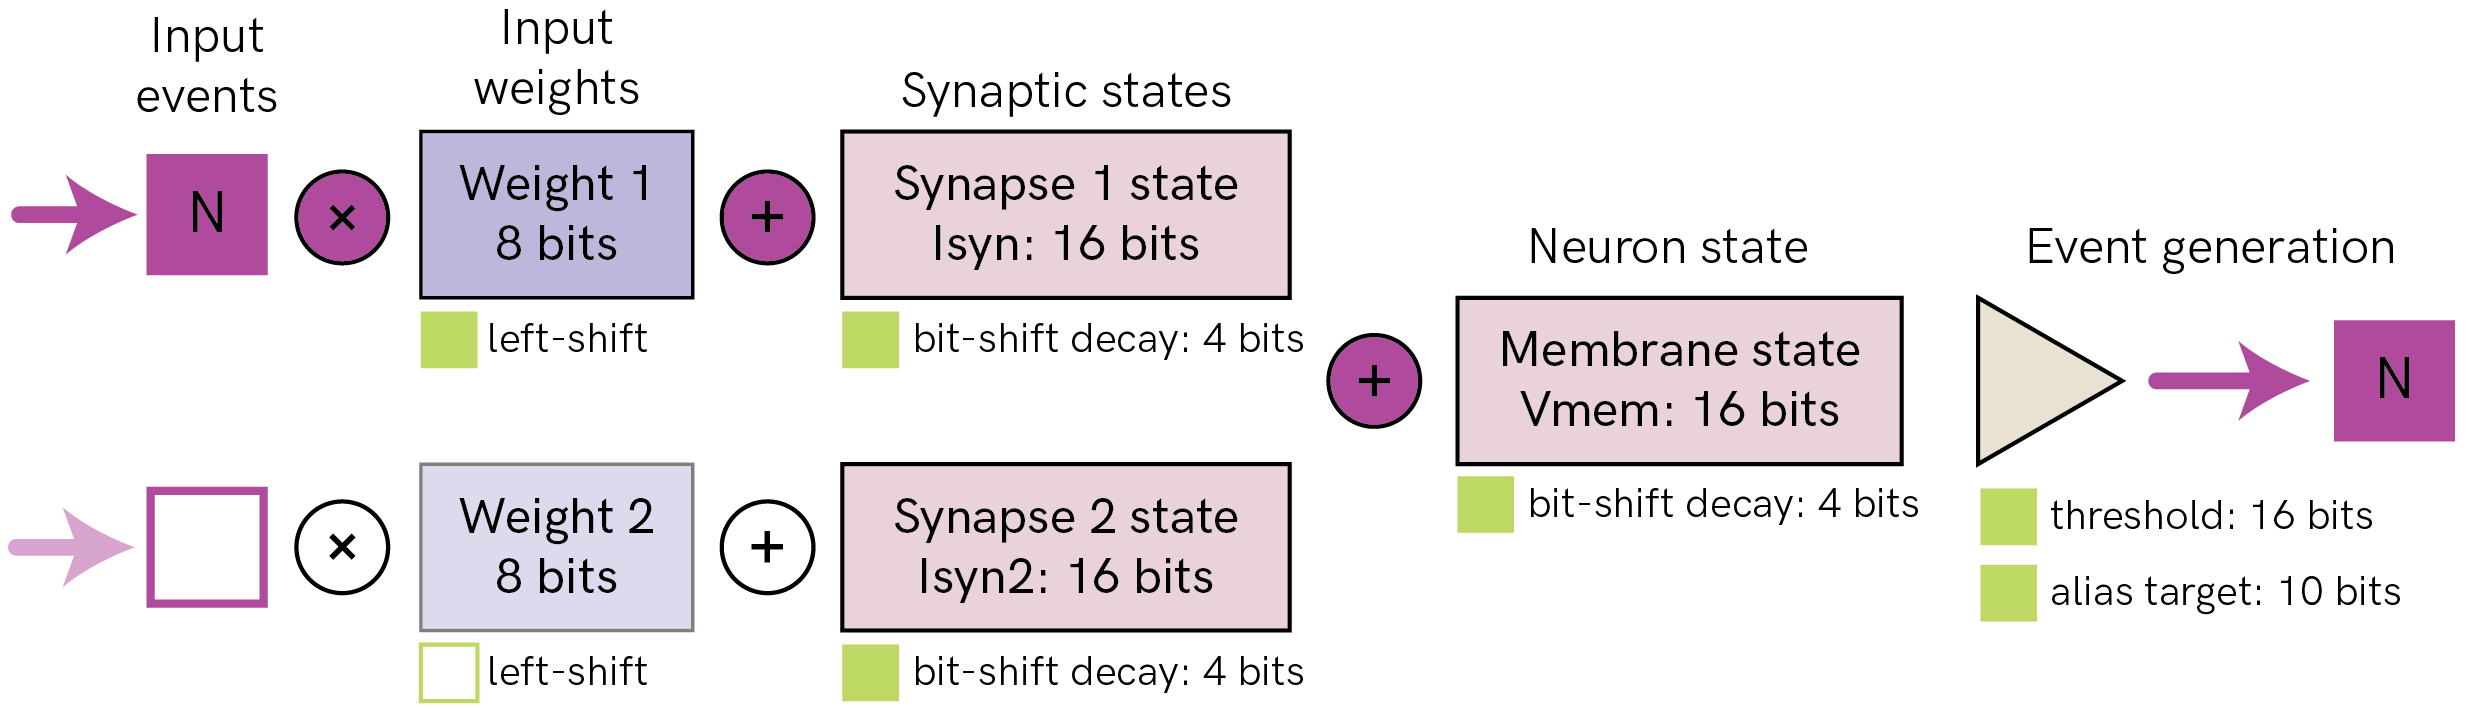

In [2]:
Image("images/pollen_neuron-model.png")

## Setting up a Pollen simulation

In [1]:
# - Rockpool imports
from rockpool.devices import pollen
from rockpool import TSContinuous, TSEvent

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

try:
    from rich import print
except:
    pass

import numpy as np

/Users/Shared/anaconda3/envs/py36_tf/lib/python3.6/site-packages/samna
finished bindings


In [2]:
# - Define a network
dt = 1e-3
Nin = 1
Nhidden = 1
Nout = 1

# - Build a Pollen simulation module from a specification
mod_cimulator = pollen.PollenCim.from_specification(
    weights_in = 127 * np.ones((Nin, Nhidden, 2), 'int'),
    weights_out = 127 * np.ones((Nhidden, Nout), 'int'),
    dash_syn = 4 * np.ones(Nhidden, 'int'),
    dash_mem = 4 * np.ones(Nhidden, 'int'),
    dt = dt,
)

# - Simulate the evolution of the network on Pollen
T = 1000
input_rate = 0.01
input_raster = np.random.rand(T, Nin) < input_rate
output_raster, _, _ = mod_cimulator(input_raster)

In [3]:
# - Simulate evolution and record internal state
_, _, rec_state = mod_cimulator(input_raster, record = True)

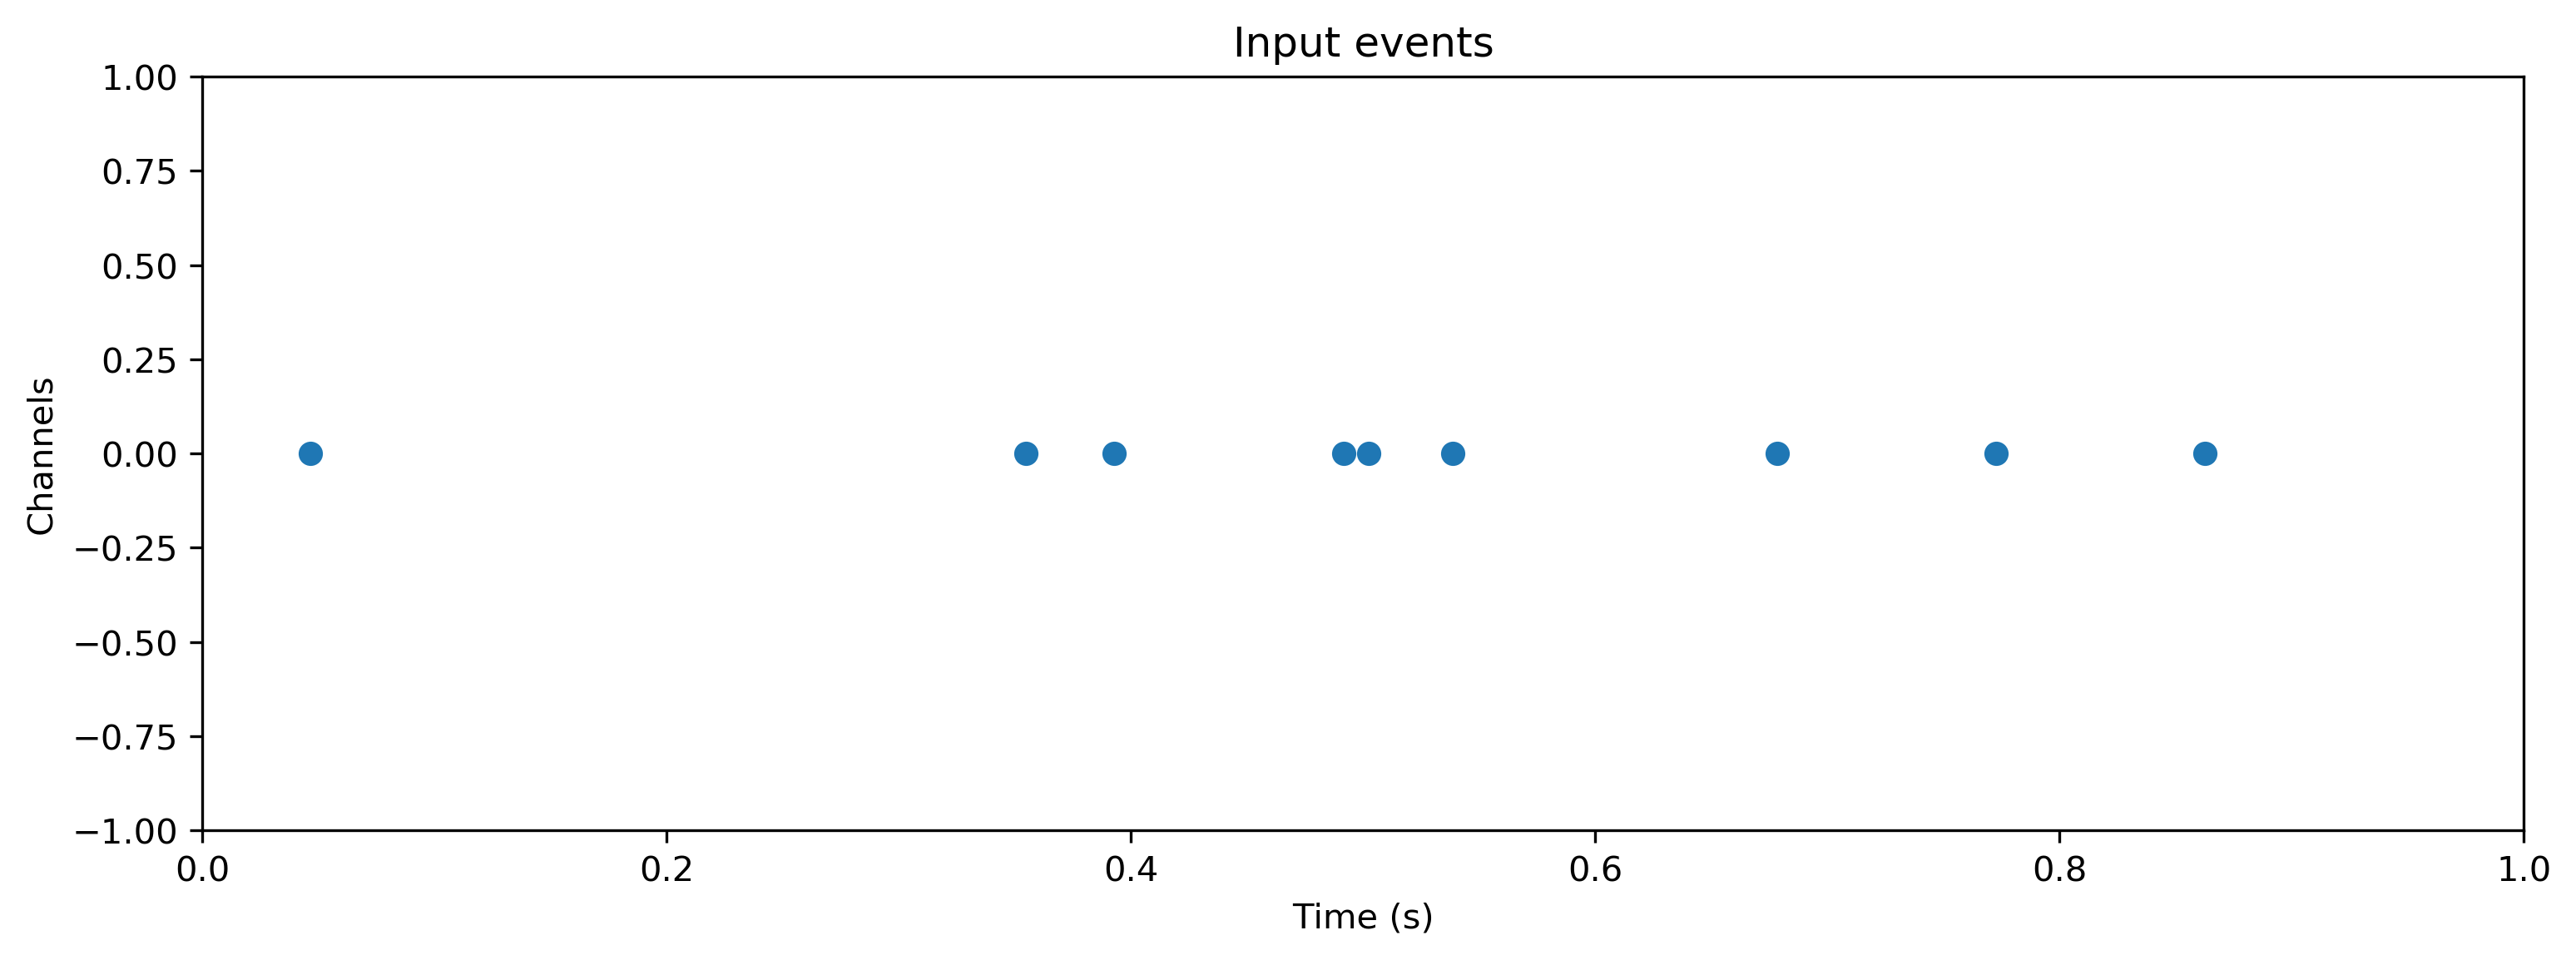

In [4]:
TSEvent.from_raster(input_raster, dt = dt, name = 'Input events').plot();

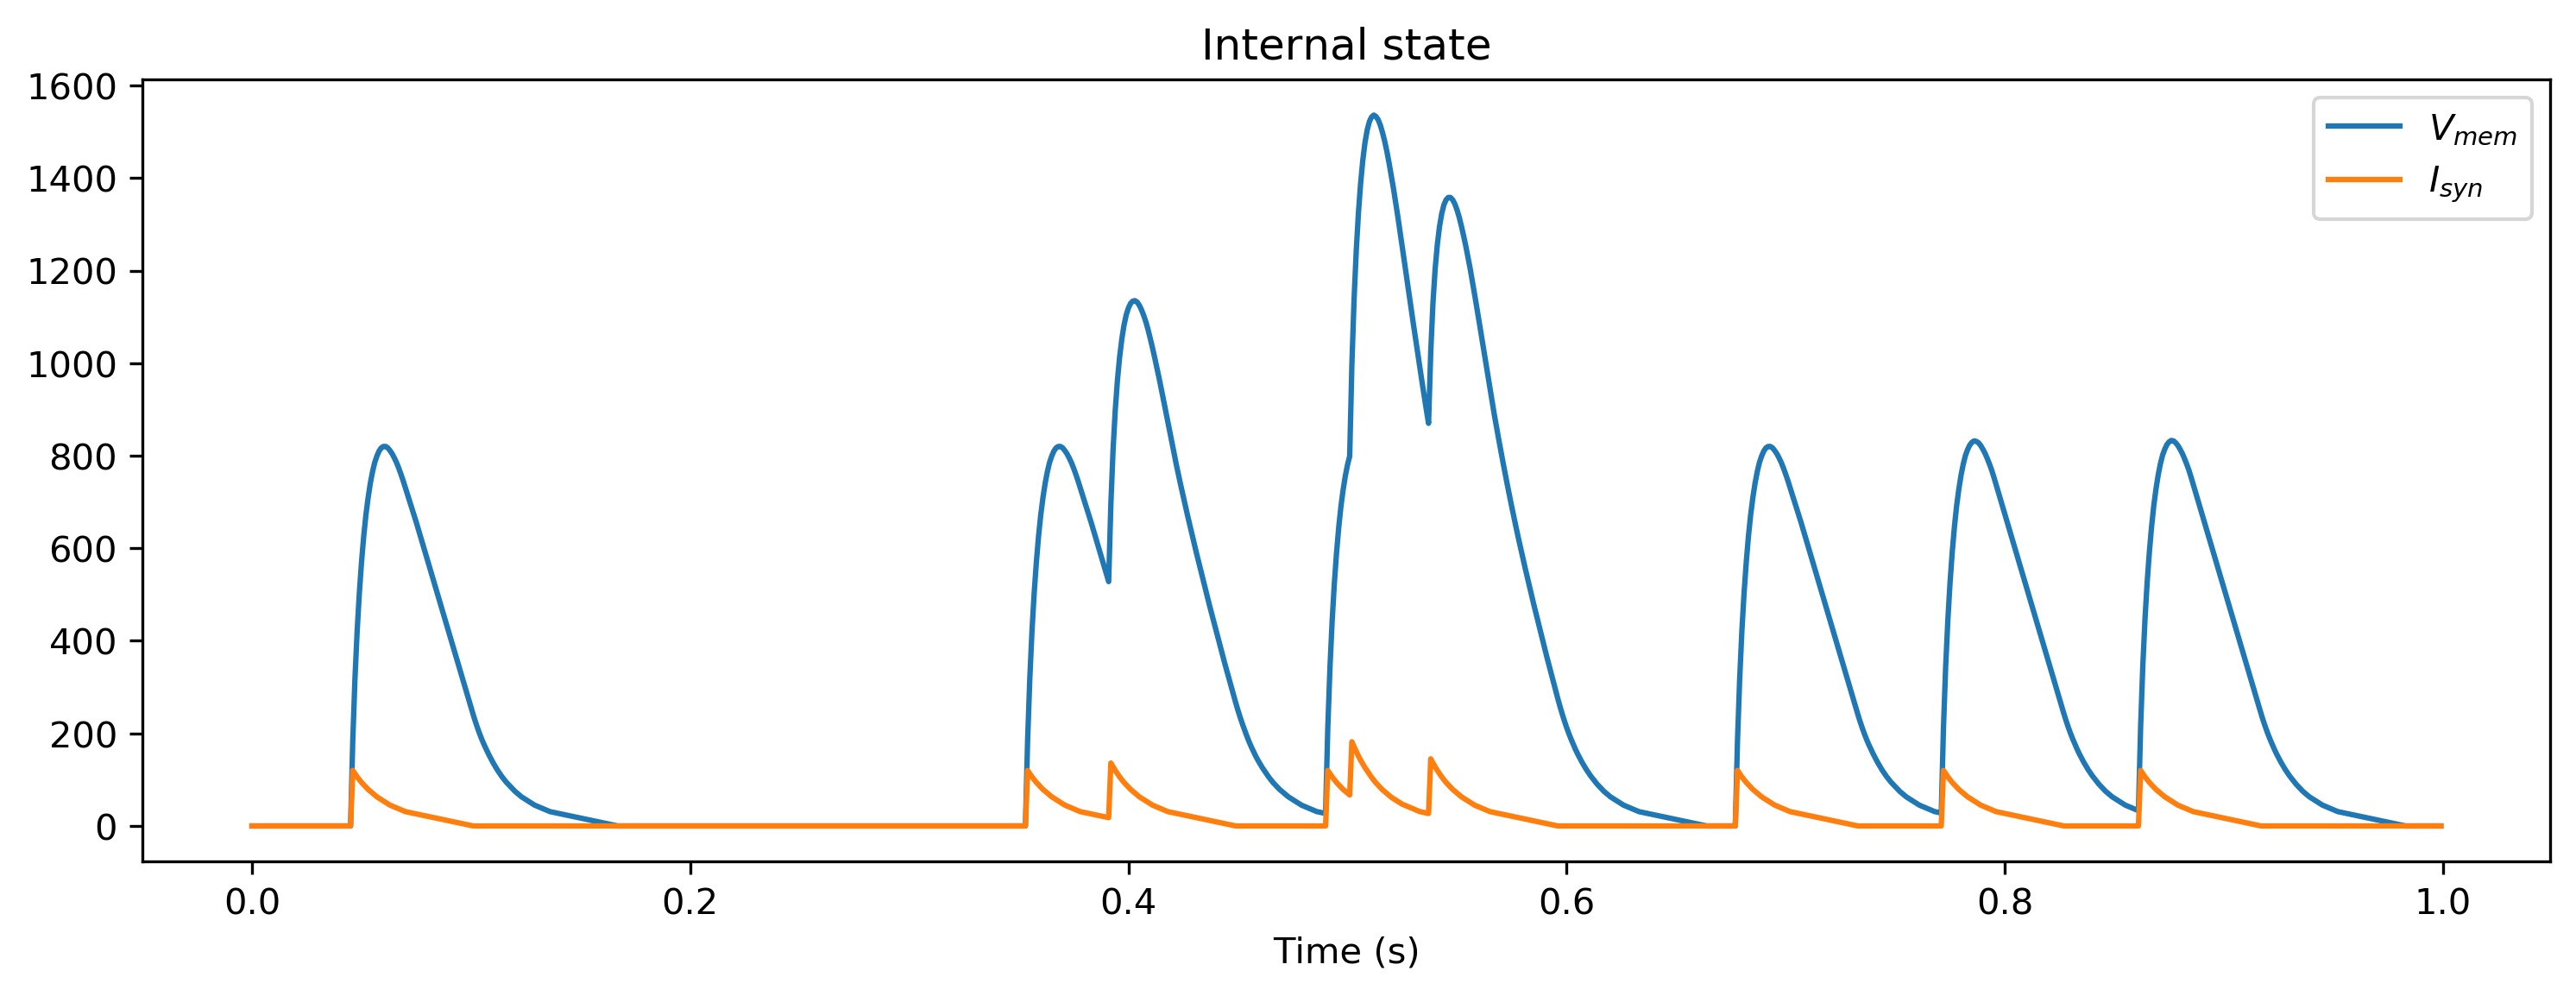

In [5]:
# - Display the internal state
print('Available state traces:', rec_state.keys())

TSContinuous.from_clocked(rec_state['vmem'], dt = dt, name = '$V_{mem}$').plot()
TSContinuous.from_clocked(rec_state['isyn'], dt = dt, name = '$I_{syn}$').plot()
plt.title('Internal state')
plt.legend();

## Moving a network to HW

### Create a local Samna node

In [8]:
# - Samna
import samna

# receiver and sender endpoints for the local nodes
# Use any free port number instead of 33378
receiver_endpoint = "tcp://0.0.0.0:31378"
sender_endpoint = "tcp://0.0.0.0:31379"

# Every node must have a unique ID
node_id = 1
interpreter_id = 2

# Construct the device node from Python. To interact with it we will
# later need to connect to it as if it was a remote node.
samna_node = samna.SamnaNode(sender_endpoint, receiver_endpoint, node_id)

# Make a local node that can be interacted with from Python
samna.setup_local_node(receiver_endpoint, sender_endpoint, interpreter_id)

# Open the samna_node we first constructed as a remote node and give it the
# name "device_node".
# The contents of the node are now available as the Python submodule samna.device_node
samna.open_remote_node(node_id, "device_node")

### Open a dev kit device

In [9]:
# Get all connected, but opened devices, supported by Samna.
devices = samna.device_node.DeviceController.get_unopened_devices()

# Open the only device
n = samna.device_node.DeviceController.open_device(devices[0], "pollen_dev_kit")

IndexError: list index out of range

In [10]:
# - Create a Pollen Module using this device node
mod_pollen = pollen.pollen_samna(n, config = c, dt = dt)

NameError: name 'n' is not defined

In [11]:
# - Evolve the network on the Pollen dev kit
output_raster, _, _ = mod_pollen(input_raster)

NameError: name 'mod_pollen' is not defined

In [12]:
# - Evolve the network and record the internal state
_, _, rec_state = mod_pollen(input_raster, record = True)

NameError: name 'mod_pollen' is not defined